# Caribbean and Hawaiian Marine (Reef) Life Image Classification Capstone Project
### Ryan Johnson

### Project Overview
As an avid snorkeler and someone who has always been interested in the unique Marine reef life ecosystem that exists within the water, I have taken many trips to explore reefs in the ocean and taken enormous amounts of images underwater. Still, I am always at a loss for what I am taking an image of; some marine life creatures I know quite well, including a green sea turtle, but others I am at a complete loss in identifying. The image classification model will create a system in which I can upload distinct sea creatures, and the model can properly identify and allow me to know what exactly I am looking at without needing a guide key to identify different underwater animals and fish that exist. The image classification model is simply a way to speed up my comprehension of the underwater creatures and ecosystems I have explored and identify what the sea creatures are when snorkeling in the ocean with my GoPro when taking enormous amounts of pictures and videos.

### Problem Statement
My capstone project aims to create a Caribbean and Hawaiian Marine (reef) life Single-label image classification model to identify different sea creatures, including sea animals and fish. 

### Caribbean and Hawaiian Marine (Reef) Life Image Classification (Single Label)
The five sea creatures and fish labels I have include:
* Cuttlefish
* Eagle ray
* Green Sea Turtle
* Reef triggerfish
* Stingray

Each of these classes of sea creatures has over 65 images and are a distinct sea creature for creating the single-label image classification model. I took these pictures using my GoPro when snorkeling in the Caribbean and Hawaiian oceans from 2017 to 2025. For my GoPro I have filter lens that help me take a clear image underwater, that is my some of the images have a warming color tone than others. I have 1162 images in total. 


When creating the image classification dataset and annotating the images and videos into each of the label classes there are:
* Cuttlefish- 65 images
* Eagle ray- 366 images
* Green Sea Turtle- 482 images
* Reef triggerfish- 67 images
* Stingray- 182 images

The images are comprised orginal images and videos stripped to 1 image(frame) per second.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
import tensorflow as tf

# to build dataset in tensorflow need use datasets
from tensorflow.keras import datasets, layers, models

import torch
import torchvision
#import torchvision.transforms as transforms

import sys
import os
from os import listdir

import PIL # Python Imaging Library
from IPython.display import display # Display Images
import pathlib

import random # to set the seed

# confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report


### Using Roboflow's API to Download Dataset into GitHub

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="") # removed api_key becuase it is tied to my Roboflow account.
project = rf.workspace("protozoa").project("caribbean-and-hawaii-marine-life")
version = project.version(1)
dataset = version.download("folder")           

### Caribbean-and-Hawaii-Marine-Life-1 version 1 dataset path

In [2]:
# Caribbean-and-Hawaii-Marine-Life-1 version 1 dataset path
# dataset_path = dataset.location  # folder where the dataset is downloaded

# Needed to put 'r' in front of dataset path to work correctly
dataset_path = r'C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1'

print(dataset_path)

# to remove error use 'r'
# SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape


C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1


### Train, Valid, and Test Dataset Paths

In [3]:
folder_paths_tvt = []
for root, directs, files in os.walk(dataset_path):
    for direct in directs:
        folder_paths_tvt.append(os.path.join(root, direct))

# Print the folder paths
for folder_path in folder_paths_tvt[0:3]:
    print(folder_path)

C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\test
C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\train
C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\valid


#### Train Data Path

In [4]:
train_data_path = folder_paths_tvt[1]
print(f'Train Data Path:\n{train_data_path}')

Train Data Path:
C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\train


#### Valid Data Path

In [5]:
valid_data_path = folder_paths_tvt[2]
print(f'Valid Data Path:\n{valid_data_path}')

Valid Data Path:
C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\valid


#### Test Data Path

In [6]:
test_data_path = folder_paths_tvt[0]
print(f'Test Data Path:\n{test_data_path}')

Test Data Path:
C:\Users\rthom\Documents\GitHub\Caribbean-and-Hawaiian-Marine-Reef-Life-Image-Classification\Caribbean-and-Hawaii-Marine-Life-1\test


### Listed Directories from the Dataset (Folders for Each of the Classes)

In [7]:
# img_dir = dataset_path

In [8]:
total_files = 0
# root, directory, files in the path of the folder
for root, direc, files in os.walk(str(dataset_path)):
    
    # spliting up the levels of folder files within the main folder
    folder_levels = root.replace(str(dataset_path), '').count(os.sep)
    
    # adding spacing to directories
    spacing = ' ' * (folder_levels) * 5
    
    print(f'{spacing}{os.path.basename(root)}/ ({len(files)} files)')
    total_files += len(files)
    
print()   
print(f'There are {total_files -2} images in this dataset')

Caribbean-and-Hawaii-Marine-Life-1/ (2 files)
     test/ (0 files)
          Cuttlefish/ (6 files)
          Eagle ray/ (36 files)
          Green Sea Turtle/ (48 files)
          Reef triggerfish/ (7 files)
          Stingray/ (17 files)
     train/ (0 files)
          Cuttlefish/ (46 files)
          Eagle ray/ (260 files)
          Green Sea Turtle/ (337 files)
          Reef triggerfish/ (47 files)
          Stingray/ (131 files)
     valid/ (0 files)
          Cuttlefish/ (13 files)
          Eagle ray/ (70 files)
          Green Sea Turtle/ (97 files)
          Reef triggerfish/ (13 files)
          Stingray/ (34 files)

There are 1162 images in this dataset


## Creating training validation, and test datasets for Caribbean and Hawaiian Marine Life Images

### Setting the seed to reproduce results

In [9]:
set_seed = 48

os.environ['PYTHONHASHSEED']=str(set_seed)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(set_seed)
np.random.seed(set_seed)
tf.random.set_seed(set_seed)

### Loading and Preprocessing Caribbean and Hawaiian Marine Life Images

In [10]:
batch_size = 32
image_height = 500 # the image is (500, 500)
image_width = 500
channels = 3 # Channel is (3) for RGB colors

In [11]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_path, # train folder contains all the folders contaning the 5 marine life creatures
  labels='inferred', # labels are generated from the directory structure
  label_mode='int', 
    
    # 'categorical' causes errors needs to be 'int'
    
    #'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    # 'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
    
  #validation_split= train_test_split,
  #subset="training",
  seed= set_seed, # seed is 123
  image_size=(image_height, image_width),
  batch_size=batch_size
)

Found 821 files belonging to 5 classes.


In [12]:
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
  valid_data_path, # valid folder contains all the folders contaning the 5 marine life creatures
  labels='inferred', # labels are generated from the directory structure
  label_mode='int', 
    # 'categorical' causes errors needs to be 'int'
    
    #'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    # 'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
    
  seed= set_seed, # seed is 123
  image_size=(image_height, image_width),
  batch_size=batch_size
)

Found 227 files belonging to 5 classes.


In [13]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_path, # test folder contains all the folders contaning the 5 marine life creatures
  labels='inferred', # labels are generated from the directory structure
  label_mode='int', 
    # 'categorical' causes errors needs to be 'int'
    
    #'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    # 'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
    
  seed= set_seed, # seed is 123
  image_size=(image_height, image_width), # 500, 500
  batch_size=batch_size
)

Found 114 files belonging to 5 classes.


### Caribbean and Hawaiian Marine Life Images Label Classes

In [14]:
car_hawai_labels = train_data.class_names
print(f'The Classes for the Caribbean and Hawaiian Marine Life Images are:\n{car_hawai_labels}')

The Classes for the Caribbean and Hawaiian Marine Life Images are:
['Cuttlefish', 'Eagle ray', 'Green Sea Turtle', 'Reef triggerfish', 'Stingray']


### Training Images of Caribbean and Hawaiian Marine Life

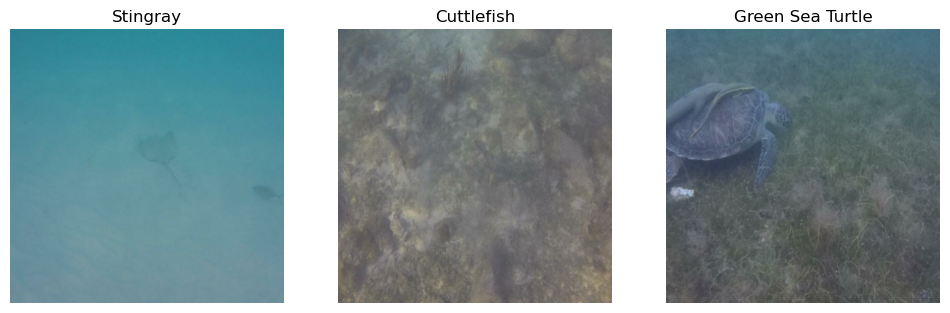

In [15]:
plt.figure(figsize=(12, 12))
for imag, lab in train_data.take(1): # take(1) for the 1 batch (32 images)
    for i in range(3):
        ax = plt.subplot(2, 3, i + 1) # better spacing
        plt.axis("off") # not axis
        plt.imshow(imag[i].numpy().astype("uint16"))
        plt.title(car_hawai_labels[lab[i]])

In [16]:
for imag, lab in train_data.take(1):
    print(f'Image Batch Shape: {imag.shape}\nLabel Batch Shape: {lab.shape}')
    
# Image Batch Shape:
# 1. number of images per batch (32)
# 2. Height of the image (500)
# 3. Width of the image (500)
# 4. Channel is (3) for RGB colors

Image Batch Shape: (32, 500, 500, 3)
Label Batch Shape: (32,)


### Optimizing Performance for the Caribbean and Hawaiian Marine life dataset
Speeding up training by reducing how the data is loaded from GitHub. TensorFlow engine can iterate over the images and process them in a streaming fashion. 
* cache() stores the dataset after loading them off the disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. 
* shuffle() is used for making the data order random, preventing overfiting to occur.
* prefetch() overlaps with data preprocessing and model execution while training.

In [17]:
autotune = tf.data.AUTOTUNE # autotune for runtime to have the optimal performance.

# train dataset optimization
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=autotune)

# valid dataset optimization
valid_data = valid_data.cache().prefetch(buffer_size=autotune)

# test dataset optimization
test_data = test_data.cache().prefetch(buffer_size=autotune)

### Data Normalization

In [18]:
# normalize the data
# using layers.experimental.preprocessing convert to number of 1 and 0
# rescaling range of the pixel values in the images is between 0 and 255.

normalize_layer = tf.keras.layers.Rescaling(1.0/255.0)

### Creating Convolutional Neural Network (CNN) Model for Marine Life Images
Goal: Classify caribbean and hawaiian marine life images into categories (labels).

In [19]:
# Image Batch Shape:
# 1. number of images per batch (32)-- batch_size = 32
# 2. Height of the image (500)-- image_height = 500 
# 3. Width of the image (500)-- image_width = 500
# 4. Channel is (3) for RGB colors-- channels = 3 

print(f'There are {channels} channels in the marine life images (RGB colors).')

num_class = len(car_hawai_labels) # number of classes(labels) of marine life species
print(f'There are {num_class} classes for the Caribbean and Hawaiian Marine life image dataset.')

marineLife_model = tf.keras.Sequential([
  # Normalization layer 
  # normalize values [0, 255] to [0, 1] to help model train with more accurately
  #                                                              Shape of input images: (500, 500, 3)
  layers.experimental.preprocessing.Rescaling(1.0/255.0, input_shape=(image_height, image_width, channels)),

  ### Convolutional layers ### -----------------------------------

  # padding='same' is used to keep the output size the same as input 
  # activation='relu' is used to lean about patterns by using non-linearity
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), # 2x2 window- downsampling the images

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # layers.Conv2D(256, 3, padding='same', activation='relu'), # don't use leads to overfitting
  # layers.MaxPooling2D(),

  #--------------------------------------------------------------

  layers.Flatten(), # Flatten Layer
  layers.Dense(256, activation='relu'), # Dense layer

  # add dropout layer to help prevent overfitting (dropping 50% of neurons)
  layers.Dropout(0.5),

  # Output layer
  # 5 neurons based the the labels
  layers.Dense(num_class, activation='softmax') # using softmax to ensure that each output is between [0, 1] 
                                                # helps with probabilities
])

There are 3 channels in the marine life images (RGB colors).
There are 5 classes for the Caribbean and Hawaiian Marine life image dataset.


### Marine Life CNN Model Architecture Summary

In [20]:
marineLife_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 250, 250, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 125, 125, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)      1

### Configure Marine Life model
The Marine Life model must be configured to ensure the model can be trained. There are 5 classes.

In [21]:
marineLife_model.compile(optimizer='adam', # optimizing learning rate
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

### Train the Marine Life model
Using early stopping when training the model to ensure that memory is used properly and prevent overfitting to occur.
The training will be stopped in 3 epochs if there is no improvement.

In [ ]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 4) # stoped in 3 epochs if no improvement
history = marineLife_model.fit(train_data,
                                 epochs= 25, # 20
                                 validation_data= valid_data,
                                 callbacks= [callback], verbose= 1)

# 3 stopped and 20 eppoch
# - loss: 0.6254 - accuracy: 0.7491 - val_loss: 0.8048 - val_accuracy: 0.7401
# CPU times: total: 2h 30min 33s
# Wall time: 16min 34s

Epoch 1/25


26/26 [==============================] - 61s 2s/step - loss: 1.5027 - accuracy: 0.3703 - val_loss: 1.1885 - val_accuracy: 0.5507
Epoch 2/25
26/26 [==============================] - 58s 2s/step - loss: 1.1877 - accuracy: 0.5006 - val_loss: 1.1800 - val_accuracy: 0.4670
Epoch 3/25
26/26 [==============================] - 60s 2s/step - loss: 1.1455 - accuracy: 0.5274 - val_loss: 0.9946 - val_accuracy: 0.5859
Epoch 4/25
26/26 [==============================] - 59s 2s/step - loss: 1.0022 - accuracy: 0.5883 - val_loss: 0.9159 - val_accuracy: 0.6344
Epoch 5/25
26/26 [==============================] - 60s 2s/step - loss: 0.9496 - accuracy: 0.6029 - val_loss: 0.8926 - val_accuracy: 0.6432
Epoch 6/25
26/26 [==============================] - 59s 2s/step - loss: 0.9509 - accuracy: 0.6054 - val_loss: 0.9146 - val_accuracy: 0.6608
Epoch 7/25
26/26 [==============================] - 61s 2s/step - loss: 0.8995 - accuracy: 0.6468 - val_loss: 0.8674 - val_accuracy: 0.6211
Epoch 8/25
26/26 [=============

In [24]:
loss, acc = marineLife_model.evaluate(valid_data)
print(f'Loss: {round(loss, 6)}\nAccuracy: {round(acc, 6)}')

8/8 [==============================] - 3s 353ms/step - loss: 0.7155 - accuracy: 0.7841
Loss: 0.715456
Accuracy: 0.784141
